# Import packages:


In [1]:
import random
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import pearsonr, randint, uniform
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sktime.split import ExpandingWindowSplitter
from sktime.transformations.series.impute import Imputer
from tqdm.notebook import tqdm

In [2]:
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
models_path = Path("../results/models/vegetation/")

# Load data:


In [4]:
vegetation_indices_df = pd.read_parquet(
    "../data/processed/vegetation_indices/vegetation_indices_monthly.parquet"
)

In [5]:
vegetation_indices_df.dtypes

province            object
date        datetime64[ns]
EVI                float64
NDVI               float64
dtype: object

In [6]:
vegetation_indices_df.isna().sum()

province    0
date        0
EVI         0
NDVI        0
dtype: int64

In [7]:
olive_yield_df = pd.read_parquet("../data/processed/olive_yield/olive_yield.parquet")

# Prepare data:


In [8]:
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}

In [9]:
months_order = list(month_mapping.keys())

In [10]:
vegetation_indices_tabular_df = (
    vegetation_indices_df.assign(
        year=lambda df_: df_.date.dt.year,
        month_name=lambda df_: pd.Categorical(
            df_.date.dt.month_name(),
            categories=months_order,
            ordered=True,
        ),
    )
    .sort_values(by=["province", "date"])
    .drop(columns=["date"])
    .pivot(index=["province", "year"], columns="month_name")
)

In [11]:
vegetation_indices_tabular_df.columns = [
    f"{col[0]}_{col[1]}" for col in vegetation_indices_tabular_df.columns
]

In [12]:
vegetation_indices_tabular_df

EVI_January  EVI_February    EVI_March    EVI_April  \
province year                                                        
A Coruña 2000          NaN   3738.468622  3837.875556  4058.913004   
         2001  3715.979787   3930.382114  3239.127095  4372.615629   
         2002  3375.861173   4158.396417  3946.878992  4271.132688   
         2003  3886.134963   4204.037364  4018.542452  4499.736251   
         2004  4087.799849   3915.585971  3776.795233  4107.853227   
...                    ...           ...          ...          ...   
Ávila    2018  1880.778150   2117.108232  2572.815371  3172.643164   
         2019  2596.593711   2752.427497  3086.733220  3216.268245   
         2020  2604.530951   3066.721093  3407.454687  3655.983497   
         2021  2408.147815   2929.643348  3252.994972  3733.677286   
         2022  2629.701785   2669.466410  2946.302329  3420.485404   

                   EVI_May     EVI_June     EVI_July   EVI_August  \
province year                                                       
A Coruña 2000  4706.062028  4797.657555  4633.772551  4382.261753   
         2001  4817.471471  4415.796839  4789.153623  4698.979349   
         2002  4659.780869  4925.536718  4632.642472  4353.545242   
         2003  4743.388972  5152.820004  4845.426506  4482.658087   
         2004  4668.100018  4686.766234  4636.734484  4505.352286   
...                    ...          ...          ...          ...   
Ávila    2018  3423.248841  3436.985187  2815.151600  2607.752132   
         2019  2970.749614  2597.099302  2342.229896  2236.897395   
         2020  3758.084669  3038.884135  2495.001324  2417.190420   
         2021  3678.128474  2955.955563  2521.799271  2330.207327   
         2022  3447.031631  2794.900411  2391.237443  2290.130588   

               EVI_September  EVI_October  ...   NDVI_March   NDVI_April  \
province year                              ...                             
A Coruña 2000    4445.958704  4303.285838  ...  6606.549675  6752.119118   
         2001    4128.205245  4339.305966  ...  5240.065113  7255.940980   
         2002    4325.904482  4140.760369  ...  7033.406270  6926.651338   
         2003    4296.507659  4054.104059  ...  6974.770087  7322.116972   
         2004    4600.831695  3865.834267  ...  6646.091856  6884.957996   
...                      ...          ...  ...          ...          ...   
Ávila    2018    2443.757578  2385.010256  ...  4277.253193  5035.290781   
         2019    2361.941284  2412.598445  ...  5184.621563  5336.769921   
         2020    2385.081183  2648.492438  ...  5686.193391  5660.769939   
         2021    2571.352316  2708.705306  ...  5500.952004  5807.952969   
         2022    2347.315891  2012.253609  ...  4961.091323  5717.736148   

                  NDVI_May    NDVI_June    NDVI_July  NDVI_August  \
province year                                                       
A Coruña 2000  7214.755863  7416.969495  7394.567145  7094.394186   
         2001  7319.634668  6507.052108  7573.176386  7546.388541   
         2002  7275.518041  7546.119645  7300.360131  7359.869538   
         2003  7554.459122  7503.407109  7516.688533  7465.551196   
         2004  7297.430220  7410.075059  7245.085860  7288.068265   
...                    ...          ...          ...          ...   
Ávila    2018  5171.911739  5376.073994  4459.015465  4156.388896   
         2019  4726.745578  3988.284066  3643.724082  3649.610251   
         2020  5800.399491  4727.144680  4094.396854  3894.872076   
         2021  5718.167476  4769.386468  4208.771117  3884.845442   
         2022  5426.109508  4321.882342  3713.925357  3666.682573   

               NDVI_September  NDVI_October  NDVI_November  NDVI_December  
province year                                                              
A Coruña 2000     7406.591211   7519.787271    6202.132702    5806.700916  
         2001     7132.591880   7148.973052    7404.997948    7196.617906  
         2002  

### Fill missing values


In [13]:
columns_to_impute = vegetation_indices_tabular_df.columns[
    vegetation_indices_tabular_df.isna().any()
]

In [14]:
print(f"Columns to impute: {columns_to_impute}")

Columns to impute: Index(['EVI_January', 'NDVI_January'], dtype='object')


In [15]:
imputer = Imputer(method="drift")

In [16]:
vegetation_indices_tabular_df.loc[:, columns_to_impute] = imputer.fit_transform(
    vegetation_indices_tabular_df.loc[:, columns_to_impute]
)

In [17]:
vegetation_indices_tabular_df.isna().sum()

EVI_January       0
EVI_February      0
EVI_March         0
EVI_April         0
EVI_May           0
EVI_June          0
EVI_July          0
EVI_August        0
EVI_September     0
EVI_October       0
EVI_November      0
EVI_December      0
NDVI_January      0
NDVI_February     0
NDVI_March        0
NDVI_April        0
NDVI_May          0
NDVI_June         0
NDVI_July         0
NDVI_August       0
NDVI_September    0
NDVI_October      0
NDVI_November     0
NDVI_December     0
dtype: int64

In [18]:
vegetation_indices_tabular_df.head()

EVI_January  EVI_February    EVI_March    EVI_April  \
province year                                                        
A Coruña 2000  3606.200418   3738.468622  3837.875556  4058.913004   
         2001  3715.979787   3930.382114  3239.127095  4372.615629   
         2002  3375.861173   4158.396417  3946.878992  4271.132688   
         2003  3886.134963   4204.037364  4018.542452  4499.736251   
         2004  4087.799849   3915.585971  3776.795233  4107.853227   

                   EVI_May     EVI_June     EVI_July   EVI_August  \
province year                                                       
A Coruña 2000  4706.062028  4797.657555  4633.772551  4382.261753   
         2001  4817.471471  4415.796839  4789.153623  4698.979349   
         2002  4659.780869  4925.536718  4632.642472  4353.545242   
         2003  4743.388972  5152.820004  4845.426506  4482.658087   
         2004  4668.100018  4686.766234  4636.734484  4505.352286   

               EVI_September  EVI_October  ...   NDVI_March   NDVI_April  \
province year                              ...                             
A Coruña 2000    4445.958704  4303.285838  ...  6606.549675  6752.119118   
         2001    4128.205245  4339.305966  ...  5240.065113  7255.940980   
         2002    4325.904482  4140.760369  ...  7033.406270  6926.651338   
         2003    4296.507659  4054.104059  ...  6974.770087  7322.116972   
         2004    4600.831695  3865.834267  ...  6646.091856  6884.957996   

                  NDVI_May    NDVI_June    NDVI_July  NDVI_August  \
province year                                                       
A Coruña 2000  7214.755863  7416.969495  7394.567145  7094.394186   
         2001  7319.634668  6507.052108  7573.176386  7546.388541   
         2002  7275.518041  7546.119645  7300.360131  7359.869538   
         2003  7554.459122  7503.407109  7516.688533  7465.551196   
         2004  7297.430220  7410.075059  7245.085860  7288.068265   

               NDVI_September  NDVI_October  NDVI_November  NDVI_December  
province year                                                              
A Coruña 2000     7406.591211   7519.787271    6202.132702    5806.700916  
         2001     7132.591880   7148.973052    7404.997948    7196.617906  
         2002     7497.848499   7092.784006    6525.544531    6542.277255  
         2003     7580.816366   7256.578442    7421.827531    7156.920250  
         2004     7429.273183   7086.915666    7472.800936    7184.313509  

[5 rows x 24 columns]

In [19]:
vegetation_indices_tabular_df = vegetation_indices_tabular_df.reset_index()

In [20]:
years = np.intersect1d(
    vegetation_indices_tabular_df["year"].unique(), olive_yield_df["year"].unique()
)

In [21]:
common_provinces = np.intersect1d(
    vegetation_indices_tabular_df["province"].unique(),
    olive_yield_df["province"].unique(),
)

In [22]:
print(f"Common years: {years}")
print(f"Common provinces: {common_provinces}")

Common years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
Common provinces: ['A Coruña' 'Alacant/Alicante' 'Albacete' 'Almería' 'Araba/Álava'
 'Asturias' 'Badajoz' 'Barcelona' 'Bizkaia' 'Burgos' 'Cantabria'
 'Castelló/Castellón' 'Ciudad Real' 'Cuenca' 'Cáceres' 'Cádiz' 'Córdoba'
 'Gipuzkoa' 'Girona' 'Granada' 'Guadalajara' 'Huelva' 'Huesca'
 'Illes Balears' 'Jaén' 'La Rioja' 'Las Palmas' 'León' 'Lleida' 'Lugo'
 'Madrid' 'Murcia' 'Málaga' 'Navarra' 'Ourense' 'Palencia' 'Pontevedra'
 'Salamanca' 'Santa Cruz de Tenerife' 'Segovia' 'Sevilla' 'Soria'
 'Tarragona' 'Teruel' 'Toledo' 'Valladolid' 'València/Valencia' 'Zamora'
 'Zaragoza' 'Ávila']


# Split data:


In [23]:
train_fraction = 0.8

In [24]:
train_years = years[: int(train_fraction * len(years))]
test_years = years[int(train_fraction * len(years)) :]

In [25]:
print(f"Train years: {train_years}")
print(f"Test years: {test_years}")

Train years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017]
Test years: [2018 2019 2020 2021 2022]


In [26]:
X_train = (
    vegetation_indices_tabular_df[
        vegetation_indices_tabular_df["year"].isin(train_years)
        & vegetation_indices_tabular_df["province"].isin(common_provinces)
    ]
    .sort_values(by=["province", "year"])
    .set_index(["province", "year"])
)


X_test = (
    vegetation_indices_tabular_df[
        vegetation_indices_tabular_df["year"].isin(test_years)
        & vegetation_indices_tabular_df["province"].isin(common_provinces)
    ]
    .sort_values(by=["province", "year"])
    .set_index(["province", "year"])
)

y_train = (
    olive_yield_df.loc[
        olive_yield_df["year"].isin(train_years), ["province", "year", "total"]
    ]
    .sort_values(by=["province", "year"])
    .set_index(["province", "year"])
)


y_test = (
    olive_yield_df.loc[
        olive_yield_df["year"].isin(test_years), ["province", "year", "total"]
    ]
    .sort_values(by=["province", "year"])
    .set_index(["province", "year"])
)

In [27]:
print(f"Vegetation X_train shape: {X_train.shape}")
print(f"Vegetation X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Vegetation X_train shape: (900, 24)
Vegetation X_test shape: (250, 24)
y_train shape: (900, 1)
y_test shape: (250, 1)


# Regression:


In [28]:
def evaluate_predictions(y_true, y_pred):
    """
    Evaluate the performance of a regression model by calculating various metrics.
    Parameters:
    - y_true (array-like): The true values of the target variable.
    - y_pred (array-like): The predicted values of the target variable.
    Returns:
    - dict: A dictionary containing the following metrics:
        - mean_absolute_error (float): The mean absolute error.
        - mean_squared_error (float): The mean squared error.
        - root_mean_squared_error (float): The root mean squared error.
        - r2_score (float): The coefficient of determination (R^2 score).
        - correlation (float): Pearson correlation coefficient.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)

    return {
        "mean_absolute_error": mae,
        "mean_squared_error": mse,
        "root_mean_squared_error": rmse,
        "r2_score": r2,
        "correlation": correlation,
    }

In [29]:
def get_feature_names(pipeline):
    if "poly" in dict(pipeline.named_steps):
        return pipeline.named_steps["poly"].get_feature_names_out(
            pipeline.named_steps["scaler"].get_feature_names_out()
        )
    else:
        return pipeline.named_steps["scaler"].get_feature_names_out()

In [30]:
def get_model_coefficients_or_importances(model):
    if hasattr(model, "coef_"):
        return model.coef_
    elif hasattr(model, "feature_importances_"):
        return model.feature_importances_
    else:
        return None

In [31]:
expanding_window_splitter = ExpandingWindowSplitter(
    fh=[
        1,
        2,
        3,
    ],
    initial_window=10,
    step_length=1,
)

In [32]:
models = [
    (
        "LinearRegression",
        LinearRegression(),
        {
            "model__fit_intercept": [True, False],
        },
    ),
    (
        "Ridge",
        Ridge(),
        {
            "model__alpha": uniform(0.0001, 1000),
            "model__fit_intercept": [True, False],
        },
    ),
    (
        "RandomForestRegressor",
        RandomForestRegressor(),
        {
            "model__n_estimators": randint(100, 501),
            "model__max_depth": randint(10, 41),
            "model__min_samples_split": randint(2, 11),
            "model__min_samples_leaf": randint(1, 5),
            "model__bootstrap": [True, False],
        },
    ),
    (
        "GradientBoostingRegressor",
        GradientBoostingRegressor(),
        {
            "model__n_estimators": randint(100, 501),
            "model__learning_rate": uniform(0.001, 0.199),
            "model__max_depth": randint(3, 10),
            "model__subsample": uniform(0.7, 0.3),
            "model__min_samples_split": randint(2, 11),
        },
    ),
    (
        "DecisionTreeRegressor",
        DecisionTreeRegressor(),
        {
            "model__max_depth": randint(5, 31),
            "model__min_samples_split": randint(2, 11),
            "model__min_samples_leaf": randint(1, 5),
            "model__max_features": [
                None,
                "sqrt",
                "log2",
            ],
        },
    ),
    (
        "XGBoostRegressor",
        xgb.XGBRegressor(),
        {
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
            "model__n_estimators": range(50, 1000, 50),
            "model__max_depth": range(3, 12),
            "model__min_child_weight": range(1, 10),
        },
    ),
    (
        "SGDRegressor",
        SGDRegressor(max_iter=1000, tol=1e-3),
        {
            "model__loss": ["squared_error", "huber", "epsilon_insensitive"],
            "model__penalty": ["l2", "l1", "elasticnet"],
            "model__alpha": uniform(0.00001, 0.01),
            "model__learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
            "model__eta0": uniform(0.001, 0.099),
        },
    ),
    (
        "SVR",
        SVR(max_iter=1000),
        {
            "model__kernel": ["linear", "rbf", "poly"],
            "model__C": uniform(0.01, 99.99),
            "model__epsilon": uniform(0.001, 0.999),
            "model__gamma": ["scale", "auto"],
        },
    ),
]

In [33]:
def run_random_search(model_name, model, param_grid, X, y):
    """
    Run a random search for hyperparameter tuning using a pipeline with optional polynomial features.
    Parameters:
    - model_name (str): The name of the model.
    - model (object): The machine learning model object.
    - param_grid (dict): The dictionary of hyperparameters to search over.
    - X (array-like): The input features.
    - y (array-like): The target variable.
    Returns:
    - random_search (object): The fitted RandomizedSearchCV object.
    """

    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", model),
        ]
    )

    if model_name in ["LinearRegression", "Ridge", "SGDRegressor"]:
        pipeline.steps.insert(1, ("poly", PolynomialFeatures()))
        param_grid["poly__degree"] = [1, 2]

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        n_iter=10,
        refit=True,
        cv=expanding_window_splitter.split(X),
        n_jobs=-1,
        random_state=random_seed,
    )

    random_search.fit(X, y["total"])

    model_path = models_path / f"{model_name}_best_model.pkl"
    joblib.dump(random_search.best_estimator_, model_path)

    return random_search

In [34]:
experiment_results = {}

for model_name, model, param_grid in tqdm(models):

    print(f"Running random search for {model_name}")

    experiment_results[model_name] = run_random_search(
        model_name, model, param_grid, X_train, y_train
    )

    print("===" * 20)

  0%|          | 0/8 [00:00<?, ?it/s]

Running random search for LinearRegression


c:\Users\Reslan Al Tinawi\Desktop\CS913-dissertation-project\cs913-dissertation-project\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running random search for Ridge
Running random search for RandomForestRegressor
Running random search for GradientBoostingRegressor
Running random search for DecisionTreeRegressor
Running random search for XGBoostRegressor
Running random search for SGDRegressor
Running random search for SVR


# Performance analysis:


In [35]:
models_metrics_df_list = []

for model_name, grid_search in experiment_results.items():
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    scores = evaluate_predictions(y_test["total"], y_pred)

    # Append the results to the list
    models_metrics_df_list.append(
        {
            "model_name": model_name,
            "mean_absolute_error": scores["mean_absolute_error"],
            "mean_squared_error": scores["mean_squared_error"],
            "root_mean_squared_error": scores["root_mean_squared_error"],
            "r2_score": scores["r2_score"],
            "correlation": scores["correlation"],
        }
    )

models_metrics_df = pd.DataFrame(models_metrics_df_list)
models_metrics_df = models_metrics_df.assign(dataset="vegetation")

In [36]:
models_metrics_df.sort_values(by="r2_score", ascending=False)

,model_name,mean_absolute_error,mean_squared_error,root_mean_squared_error,r2_score,correlation,dataset
1,Ridge,167508.010021,1.146319e+11,338573.382746,0.325127,0.573723,vegetation
0,LinearRegression,198672.842340,1.285843e+11,358586.464281,0.242985,0.505684,vegetation
6,SGDRegressor,208652.349688,1.357698e+11,368469.572709,0.200682,0.465523,vegetation
2,RandomForestRegressor,133380.047885,1.358946e+11,368638.899466,0.199947,0.499009,vegetation
5,XGBoostRegressor,151993.109375,1.388474e+11,372622.343750,0.182563,0.540760,vegetation
3,GradientBoostingRegressor,148339.689295,1.498858e+11,387150.885520,0.117577,0.506506,vegetation
7,SVR,136377.183599,1.813804e+11,425887.784908,-0.067842,0.346074,vegetation
4,DecisionTreeRegressor,157289.629391,2.126239e+11,461111.624192,-0.251782,0.374041,vegetation


In [37]:
models_metrics_df.to_clipboard()

In [38]:
good_models = models_metrics_df.loc[
    models_metrics_df["r2_score"] > 0, "model_name"
].tolist()
print(good_models)

['LinearRegression', 'Ridge', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBoostRegressor', 'SGDRegressor']


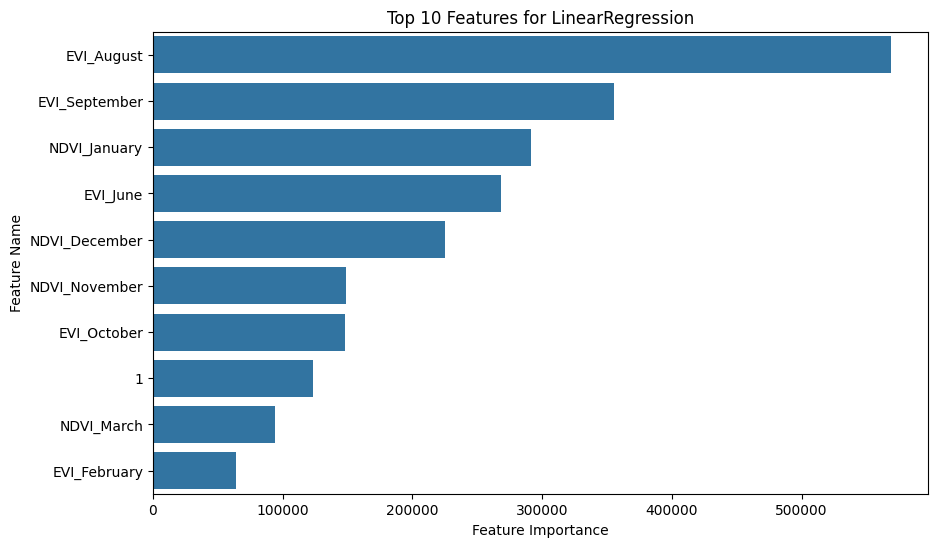

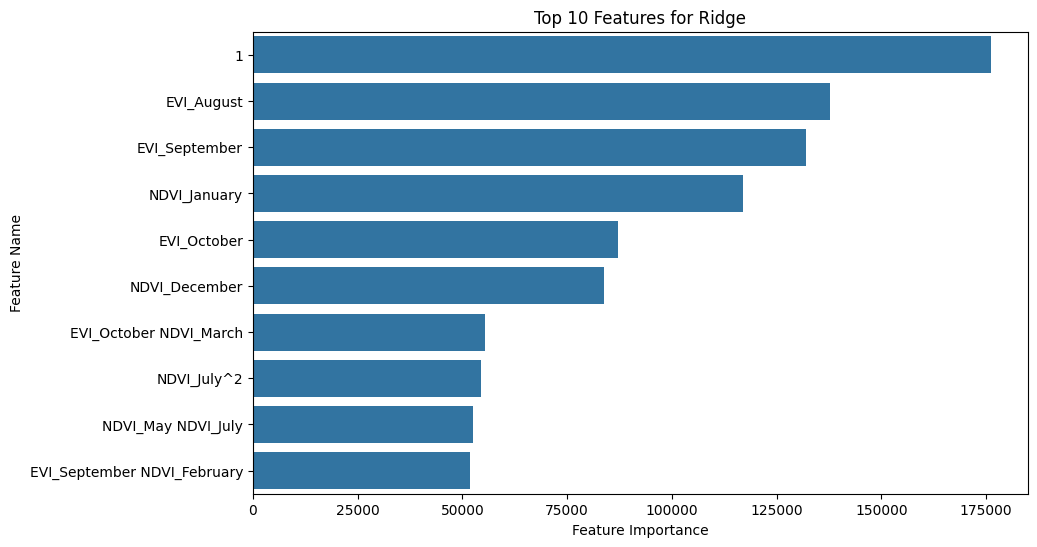

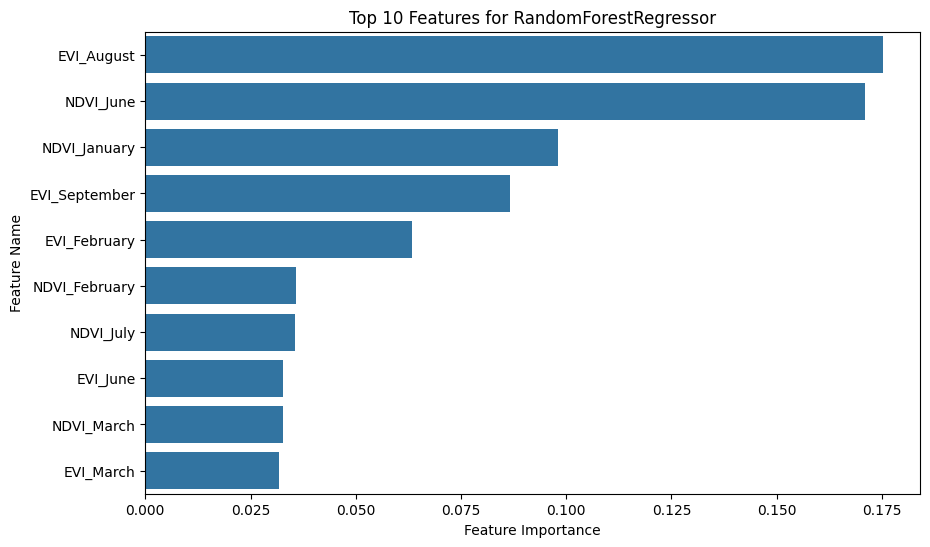

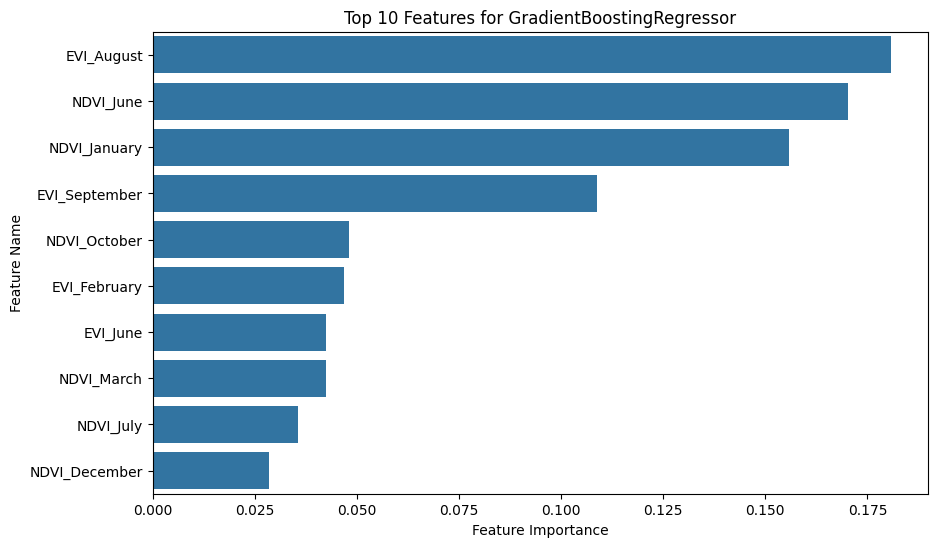

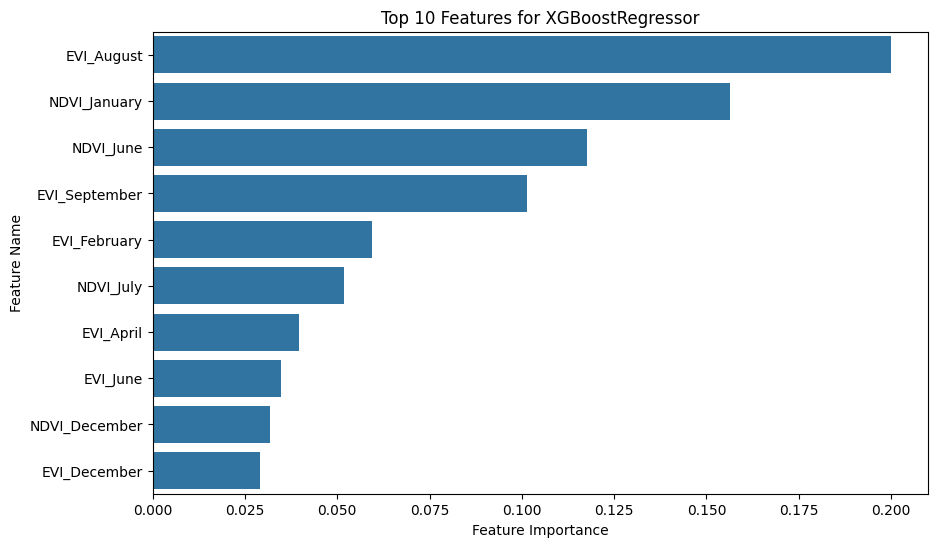

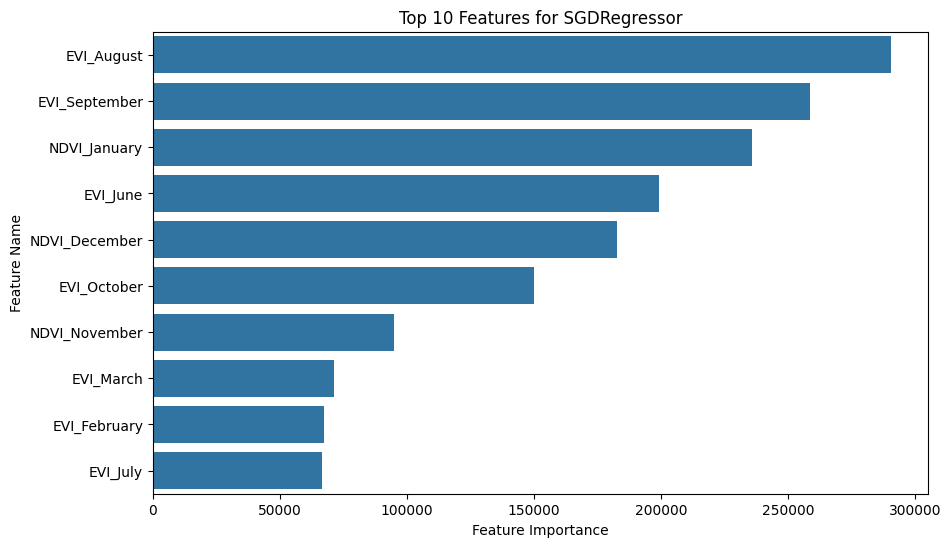

In [39]:
models_feature_importance_df_list = []

for model_name in good_models:
    best_pipeline = experiment_results[model_name].best_estimator_
    feature_names = get_feature_names(best_pipeline)
    coefficients_or_importances = get_model_coefficients_or_importances(
        best_pipeline.named_steps["model"]
    )

    if coefficients_or_importances is not None:
        model_feature_importance = (
            pd.DataFrame(
                {
                    "feature_name": feature_names,
                    "feature_importance": coefficients_or_importances.squeeze(),
                }
            )
            .sort_values(by="feature_importance", ascending=False)
            .head(10)
        )
        model_feature_importance["model_name"] = model_name
        models_feature_importance_df_list.append(model_feature_importance)

# Concatenate all results
models_feature_importance_df = pd.concat(
    models_feature_importance_df_list, ignore_index=True
)


for model in good_models:
    plt.figure(figsize=(10, 6))
    model_data = models_feature_importance_df[
        models_feature_importance_df["model_name"] == model
    ]
    sns.barplot(x="feature_importance", y="feature_name", data=model_data)
    plt.title(f"Top 10 Features for {model}")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.show()

In [40]:
for model_name in good_models:
    model = experiment_results[model_name]
    model.best_estimator_.fit(X_train, y_train["total"])
    train_pred = model.best_estimator_.predict(X_train)
    test_pred = model.best_estimator_.predict(X_test)

    y_train[f"{model_name}_total"] = train_pred
    y_test[f"{model_name}_total"] = test_pred

true_vs_pred_df = pd.concat([y_train, y_test], axis=0).reset_index()